In [1]:
# Example of maximum-likelihood fit with iminuit.
# pdf is a mixture of Gaussian (signal) and exponential (background),
# both truncated in [xMin,xMax].
# Here parameters other than signal fraction theta
# and exponential mean xi are treated as constant.
# G. Cowan / RHUL Physics / November 2020

import numpy as np
import scipy.stats as stats
from scipy.stats import truncexpon
from scipy.stats import truncnorm
from iminuit import Minuit
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14

In [2]:
# define pdf and generate data
np.random.seed(seed=1234567)        # fix random seed
theta = 0.2                         # fraction of signal
mu = 10.                            # mean of Gaussian
sigma = 2.                          # std. dev. of Gaussian
xi = 5.                             # mean of exponential
xMin = 0.
xMax = 20.

def f(x, theta, xi):
    fs = stats.truncnorm.pdf(x, a=(xMin-mu)/sigma, b=(xMax-mu)/sigma, loc=mu, scale=sigma)
    fb = stats.truncexpon.pdf(x, b=(xMax-xMin)/xi, loc=xMin, scale=xi)
    return theta*fs + (1-theta)*fb

In [3]:
numVal = 200
xData = np.empty([numVal])
for i in range (numVal):
    r = np.random.uniform();
    if r < theta:
        xData[i] = stats.truncnorm.rvs(a=(xMin-mu)/sigma, b=(xMax-mu)/sigma, loc=mu, scale=sigma)
    else:
        xData[i] = stats.truncexpon.rvs(b=(xMax-xMin)/xi, loc=xMin, scale=xi)

In [4]:
# Function to be minimized is negative log-likelihood
def negLogL(theta, xi):
    pdf = f(xData, theta, xi)
    return -np.sum(np.log(pdf))

In [5]:
# Create instance of Minuit and set up fit:
#   initial parameter values are guesses
#   error values set initial step size in search algorithm
#   limit_param to set limits on parameters (needed here to keep pdf>0).
#   fix_param=True to fix a parameter
#   errordef=0.5 means errors correspond to logL = logLmax - 0.5
#   pedantic=False to turn off verbose messages

m = Minuit(negLogL, theta=0.5, xi=5., error_theta=0.1, error_xi=0.2, limit_theta=(0., 1.), 
           limit_xi=(0, None), fix_xi=False, errordef=0.5, pedantic=False)

In [6]:
# do the fit, get errors, extract result as arrays
m.migrad()                          # minimize -logL
MLE = m.np_values()                 # parameter estimates
sigmaMLE = m.np_errors()            # their standard deviations
cov = m.np_matrix()                 # covariance matrix
rho = m.np_matrix(correlation=True) # correlation coeffs.

In [7]:
# rename for convenience below
thetaHat        = MLE[0]
sigmaThetaHat   = sigmaMLE[0]
xiHat           = MLE[1]
sigmaXiHat      = sigmaMLE[1]

# line below gives: AttributeError: 'iminuit._libiminuit.Minuit' object has no attribute 'nfit'
#npar = m.nfit
npar = len(m.np_values())
print(r'parameter index, estimate and standard deviation:')
for i in range(npar):
    print(i, MLE[i], sigmaMLE[i])

print()
print(r'parameter indices, covariance and correlation coeff.:')
nfreepar = len(cov[0])
for i in range(nfreepar):
    for j in range(nfreepar):
        print(i, j, cov[i,j], rho[i,j])

parameter index, estimate and standard deviation:
0 0.2046388058666193 0.052734483201438365
1 5.1085667979611316 0.6447893594778562

parameter indices, covariance and correlation coeff.:
0 0 0.0027969098228253996 1.0
0 1 -0.018132494205288098 -0.5316588752771374
1 0 -0.018132494205288098 -0.5316588752771374
1 1 0.41588235455534234 1.0


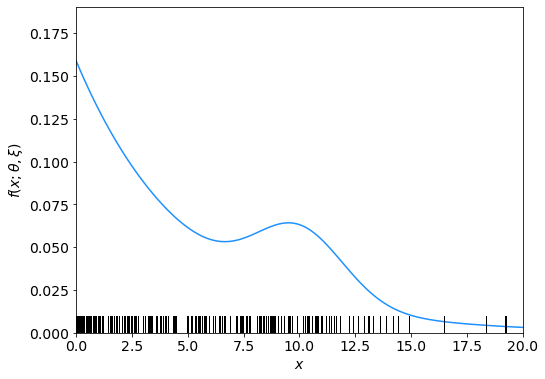

In [8]:
# Plot fitted pdf
yMin = 0.
yMax = f(0., thetaHat, xiHat)*1.2
fig = plt.figure(figsize=(8,6))
xCurve = np.linspace(xMin, xMax, 100)
yCurve = f(xCurve, thetaHat, xiHat)
plt.plot(xCurve, yCurve, color='dodgerblue')

# Plot data as tick marks
tick_height = 0.05*(yMax - yMin)
xvals = [xData, xData]
yvals = [np.zeros_like(xData), tick_height * np.ones_like(xData)]
plt.plot(xvals, yvals, color='black', linewidth=1)
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x; \theta, \xi)$')
plt.xlim(xMin, xMax)
plt.ylim(yMin, yMax)
plt.show()

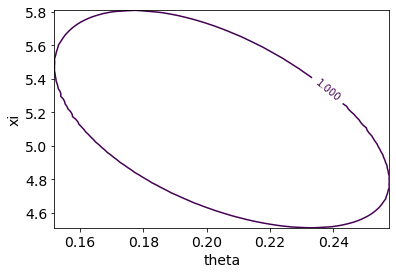

In [9]:
# Make a contour plot of lnL = lnLmax - 1/2
if nfreepar == 2:
    plt.figure()
    m.draw_mncontour('theta','xi', nsigma=1, numpoints=200);
    plt.show()